In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
#đặt một số tùy chọn hiển thị
sns.set(style="whitegrid") #đồ thị sẽ có nền trắng với các đường grid màu trắng.

Dataset này cung cấp thông tin về đặt phòng khách sạn từ (2015 - 2017) của 2 khu vực thuộc Bồ
Đào Nha (1 là khu nghỉ dưỡng khu vực thuộc Algarve và 2 là khu vực thuộc thành phố Lisbon), dữ liệu
bao gồm các trường dữ liệu như loại khách sạn, ngày đặt, thời gian lưu trú, số lượng người lớn và trẻ em,
và nhiều yếu tố khác.

Dữ liệu được thu thập với 32 trường thuộc tính và 119 390 dòng dữ liệu về nhu cầu đặt phòng của
khách hàng tại Bồ Đào Nha, với 2 loại phòng khách sạn đại diện cho 2 khu vực như sau: Resort Hotel-Khu nghĩ dưỡng tại vùng Algarve và City Hotel-thủ đô Lisbon.

In [ ]:
!pip install gdown
import gdown

# Thay thế "file_id" bằng phần ID của tệp trên Google Drive
file_id = "1w1F7ttgCNR4cKXLOjTksggqbVCI2cRPq"
url = f"https://drive.google.com/uc?id={file_id}"

# Tên tệp lưu trữ trên Colab
output = "hotel_bookings.csv"

# Tải xuống tệp dữ liệu
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1w1F7ttgCNR4cKXLOjTksggqbVCI2cRPq
To: /content/hotel_bookings.csv
100%|██████████| 16.8M/16.8M [00:00<00:00, 66.2MB/s]


'hotel_bookings.csv'

In [ ]:
import pandas as pd

# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('hotel_bookings.csv')

# Hiển thị thông tin về dữ liệu
print(data.head())

          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1     

Dựa vào bộ dữ liệu đã thu thập được chúng em tiến hành phân tích dữ liệu, sử dụng các mô hình học máy để đưa ra một dự đoán về khả năng hủy phòng của khách hàng khi đặt phòng tại khách sạn này

Sẽ rất tốt nếu các khách sạn có một mô hình để dự đoán liệu khách có thực sự đến hay không.
Điều này có thể giúp khách sạn lên kế hoạch cho những thứ như yêu cầu về nhân sự và thực phẩm.

**1) Phân tích thống kê trên dữ liệu, vẽ các đồ thị để hiểu bài toán, hiểu dữ liệu. Tìm hiểu các đặc trưng và đánh gía vai trò của các đặc trưng đối với mục tiêu bài toán;**

**Tỷ Lệ Hủy Đặt Phòng Theo Loại Hình Khách Sạn**

Biểu đồ này cho thấy số lượng đặt phòng được giữ lại (không hủy) và bị hủy theo từng loại hình khách sạn. Cột màu xanh biểu thị số lượng đặt phòng không bị hủy, trong khi cột màu cam biểu thị số lượng đặt phòng bị hủy. Sự so sánh giữa hai loại hình khách sạn cung cấp cái nhìn sâu sắc về mô hình hủy đặt phòng.

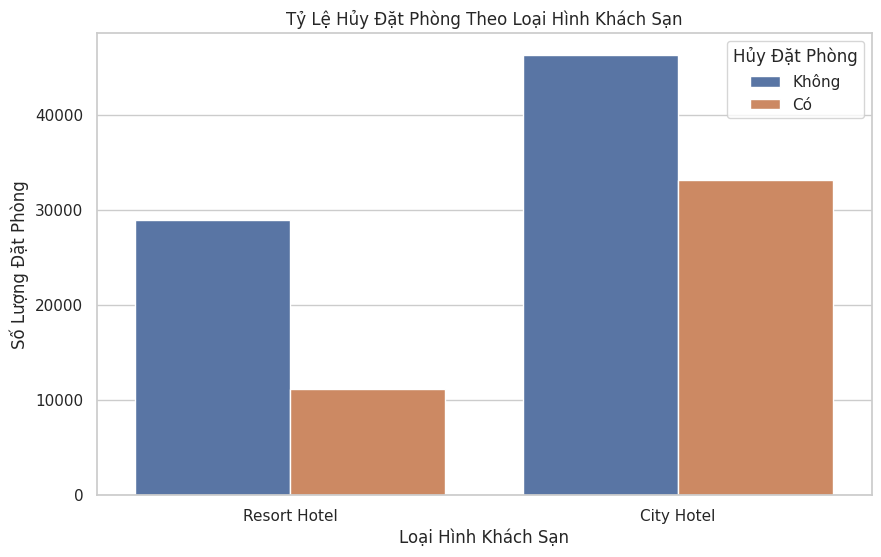

In [ ]:
# Tỷ Lệ Hủy Đặt Phòng Theo Loại Hình Khách Sạn
plt.figure(figsize=(10, 6))
sns.countplot(x='hotel', hue='is_canceled', data= data)
plt.title('Tỷ Lệ Hủy Đặt Phòng Theo Loại Hình Khách Sạn')
plt.xlabel('Loại Hình Khách Sạn')
plt.ylabel('Số Lượng Đặt Phòng')
plt.legend(title='Hủy Đặt Phòng', labels=['Không', 'Có'])
plt.show()

Loại hình khách sạn: Có ảnh hưởng đến tỷ lệ hủy đặt phòng và loại khách hàng.

**Biểu Đồ Phân Phối Thời Gian Dẫn Đầu (Lead Time):**

Biểu đồ này cho thấy sự phân bố của thời gian dẫn đầu (số ngày từ lúc đặt phòng đến ngày đến). Đây là thông tin quan trọng để xem xét liệu có mối liên hệ nào giữa thời gian dẫn đầu và việc hủy đặt phòng hay không.

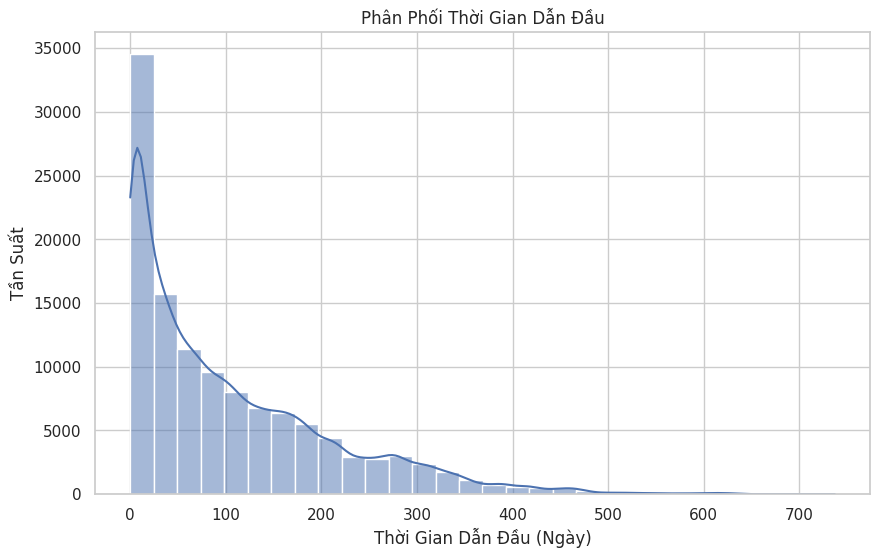

In [ ]:
# Phân tích phân phối thời gian dẫn đầu
plt.figure(figsize=(10, 6))
sns.histplot(data['lead_time'], bins=30, kde=True)
plt.title('Phân Phối Thời Gian Dẫn Đầu')
plt.xlabel('Thời Gian Dẫn Đầu (Ngày)')
plt.ylabel('Tần Suất')
plt.show()

Thời gian dẫn đầu: Có thể dự báo về khả năng hủy đặt phòng.

**Biểu Đồ Phân Phối Số Đêm Lưu Trú (Cuối Tuần so với Ngày Thường):**

Biểu đồ này so sánh số đêm lưu trú vào cuối tuần (màu xanh) và ngày thường (màu cam). Biểu đồ này giúp hiểu rõ hơn về mô hình lưu trú của khách, từ đó có thể phân tích được nhu cầu phòng theo thời gian.

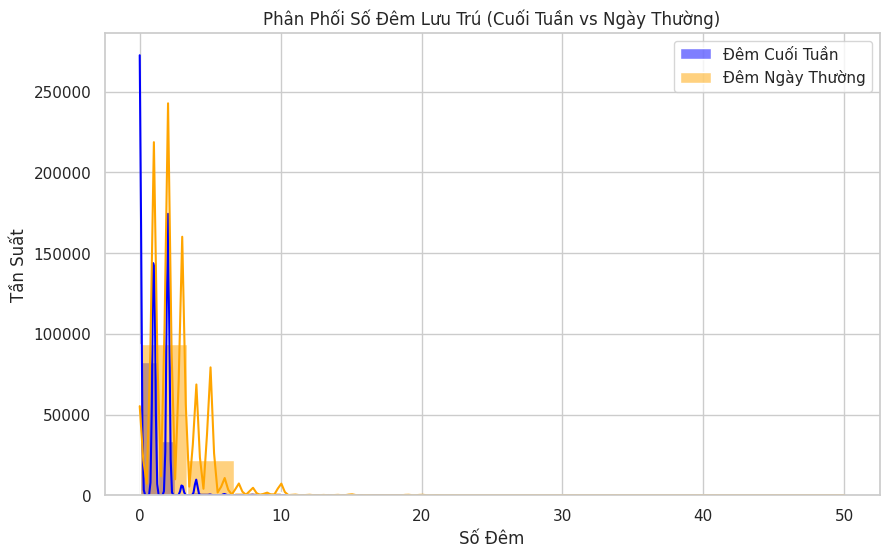

In [ ]:
# Phân tích phân phối số đêm lưu trú (cuối tuần so với ngày thường)
plt.figure(figsize=(10, 6))
sns.histplot(data['stays_in_weekend_nights'], color='blue', kde=True, label='Đêm Cuối Tuần', bins=15) #thứ 7 hoặc chủ nhật
sns.histplot(data['stays_in_week_nights'], color='orange', kde=True, label='Đêm Ngày Thường', bins=15) # thứ 2,3,4,5,6
plt.title('Phân Phối Số Đêm Lưu Trú (Cuối Tuần vs Ngày Thường)')
plt.xlabel('Số Đêm')
plt.ylabel('Tần Suất')
plt.legend()
plt.show()

Số Đêm Lưu Trú: Cung cấp thông tin về hành vi lưu trú của khách hàng, giúp trong việc dự báo nhu cầu, quản lý giá phòng, và tối ưu hóa các quy trình vận hành.

**Biểu Đồ Phân Phối Số Người Lớn, Trẻ Em, và Em Bé:**

Biểu đồ này thể hiện sự phân bố của số lượng người lớn, trẻ em, và em bé trong các đặt phòng. Điều này giúp phân tích được đối tượng khách hàng chính và nhu cầu phòng cho từng loại khách.

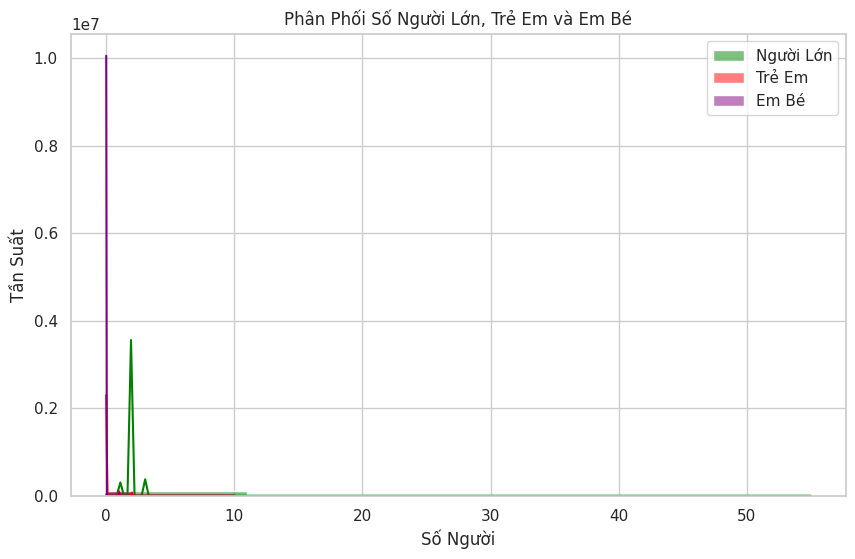

In [ ]:
# Phân tích phân phối số người lớn, trẻ em và em bé
plt.figure(figsize=(10, 6))
sns.histplot(data['adults'], color='green', label='Người Lớn', kde=True, bins=5)
sns.histplot(data['children'], color='red', label='Trẻ Em', kde=True, bins=5)
sns.histplot(data['babies'], color='purple', label='Em Bé', kde=True, bins=5)
plt.title('Phân Phối Số Người Lớn, Trẻ Em và Em Bé')
plt.xlabel('Số Người')
plt.ylabel('Tần Suất')
plt.legend()
plt.show()

Số lượng người lớn, trẻ em, và em bé giúp xác định nhu cầu và cấu trúc khách hàng, hỗ trợ trong việc lập kế hoạch dịch vụ và chiến lược tiếp thị.

**Biểu Đồ Nhiệt Độ Tương Quan (Correlation Heatmap):**

Biểu đồ này cho thấy mức độ tương quan giữa các đặc trưng khác nhau trong dữ liệu. Các giá trị tương quan gần 1 hoặc -1 cho thấy mối quan hệ mạnh mẽ giữa hai đặc trưng, trong khi giá trị gần 0 cho thấy không có mối quan hệ rõ ràng. Biểu đồ này hữu ích trong việc xác định những đặc trưng có thể ảnh hưởng đáng kể đến mục tiêu bài toán, như việc hủy đặt phòng.

<ipython-input-11-1caaab5823ba>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt=".2f")


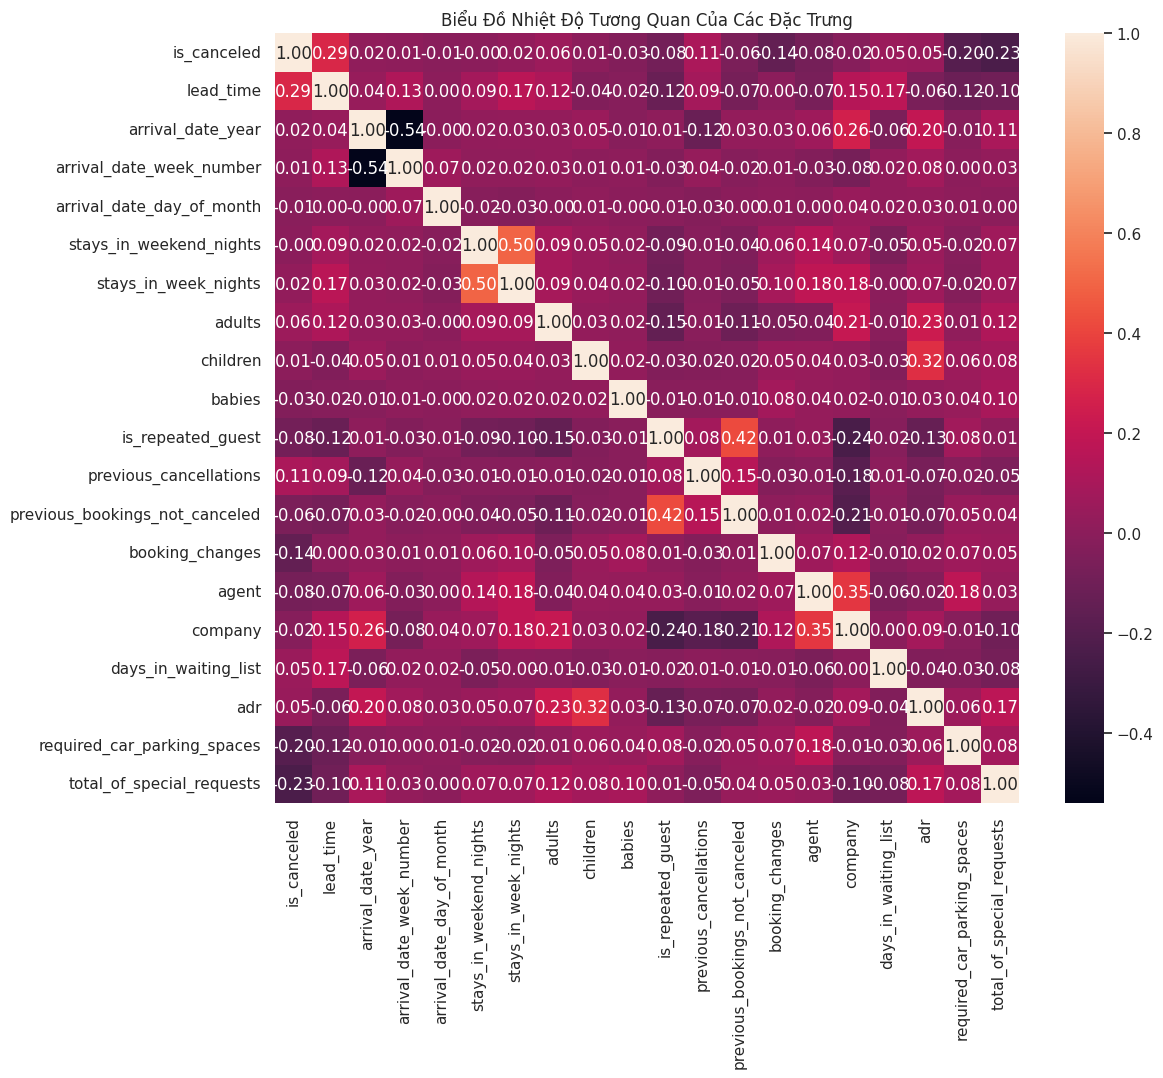

In [ ]:
# Biểu đồ nhiệt độ tương quan
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.title('Biểu Đồ Nhiệt Độ Tương Quan Của Các Đặc Trưng')
plt.show()


**2) Ứng dụng các mô hình học máy cơ bản để giải quyết bài toán, bao gồm cả các mô hình thuộc Ensemble Learing;**

***Chuẩn bị dữ liệu:***



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Mã hóa các biến phân loại
label_encoders = {}
categorical_columns = ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel',
                       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status'] # chọn ra các cột có thể liên quan tới khả năng hủy phòng.
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Điền giá trị còn thiếu
data['children'].fillna(0, inplace=True)
data['country'].fillna(data['country'].mode()[0], inplace=True)
data['agent'].fillna(0, inplace=True)
data['company'].fillna(0, inplace=True)

# Chọn đặc trưng và tách ra biến mục tiêu
features = data.drop(['is_canceled', 'reservation_status_date'], axis=1)
target = data['is_canceled']


***Chuẩn hóa dữ liệu và chia dữ liệu:***
Chuẩn hóa các đặc trưng.
Chia dữ liệu thành tập huấn luyện và tập kiểm tra.

In [ ]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)


***Huấn luyện và đánh giá các mô hình học máy:***
Xây dựng và huấn luyện mô hình Hồi quy Logistic, Rừng ngẫu nhiên, AdaBoost, và Gradient Boosting.
Đánh giá mô hình dựa trên độ chính xác và báo cáo phân loại.

1. Hồi quy Logistic (Logistic Regression)

Hồi quy Logistic là một mô hình phân loại tuyến tính được sử dụng rộng rãi, đặc biệt hữu ích trong việc dự đoán xác suất của một sự kiện nhị phân (ví dụ: hủy hoặc không hủy đặt phòng).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Huấn luyện mô hình Hồi quy Logistic
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train) #X_train (đặc trưng) và y_train (biến mục tiêu).

# Đánh giá mô hình
logistic_predictions = logistic_model.predict(X_test) #Dự đoán giá trị của biến mục tiêu trên tập kiểm tra X_test.
logistic_accuracy = accuracy_score(y_test, logistic_predictions) #Tính độ chính xác của mô hình bằng cách so sánh dự đoán với giá trị thực tế trên tập kiểm tra.
logistic_report = classification_report(y_test, logistic_predictions)
#Tạo một báo cáo chi tiết về hiệu suất của mô hình, bao gồm precision, recall, f1-score cho từng lớp và hỗn hợp.

print("Hồi quy Logistic:\nĐộ chính xác:", logistic_accuracy)
print("Báo cáo phân loại:\n", logistic_report)


Hồi quy Logistic:
Độ chính xác: 0.9899907864980316
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14907
           1       1.00      0.97      0.99      8971

    accuracy                           0.99     23878
   macro avg       0.99      0.99      0.99     23878
weighted avg       0.99      0.99      0.99     23878



2. Rừng ngẫu nhiên (Random Forest)
Rừng ngẫu nhiên là một mô hình Ensemble Learning, kết hợp nhiều cây quyết định (decision trees) để cải thiện độ chính xác và kiểm soát overfitting tốt hơn.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Huấn luyện mô hình Rừng ngẫu nhiên
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Đánh giá mô hình
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)

print("Rừng ngẫu nhiên:\nĐộ chính xác:", rf_accuracy)
print("Báo cáo phân loại:\n", rf_report)


Rừng ngẫu nhiên:
Độ chính xác: 1.0
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



3. AdaBoost
AdaBoost (Adaptive Boosting) là một mô hình tăng cường, nó cố gắng cải thiện hiệu suất của các mô hình học máy bằng cách kết hợp nhiều mô hình "yếu" thành một mô hình "mạnh".

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Huấn luyện mô hình AdaBoost
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)

# Đánh giá mô hình
ada_predictions = ada_model.predict(X_test)
ada_accuracy = accuracy_score(y_test, ada_predictions)
ada_report = classification_report(y_test, ada_predictions)

print("AdaBoost:\nĐộ chính xác:", ada_accuracy)
print("Báo cáo phân loại:\n", ada_report)


AdaBoost:
Độ chính xác: 1.0
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



4. Gradient Boosting
Gradient Boosting là một kỹ thuật tăng cường khác, nó xây dựng các mô hình tuần tự bằng cách giảm thiểu lỗi của các mô hình trước, dẫn đến một mô hình tổng hợp mạnh mẽ.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Huấn luyện mô hình Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# Đánh giá mô hình
gb_predictions = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
gb_report = classification_report(y_test, gb_predictions)

print("Gradient Boosting:\nĐộ chính xác:", gb_accuracy)
print("Báo cáo phân loại:\n", gb_report)


Gradient Boosting:
Độ chính xác: 1.0
Báo cáo phân loại:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14907
           1       1.00      1.00      1.00      8971

    accuracy                           1.00     23878
   macro avg       1.00      1.00      1.00     23878
weighted avg       1.00      1.00      1.00     23878



**3)	Sử dụng Feed Forward Neural Network và Reccurent Neural Network (hoặc mô thuộc loại này) để giải quyết bài toán**

1. Feed Forward Neural Network (FFNN)
FFNN là mô hình mạng nơ-ron cơ bản nhất, với các lớp được kết nối theo chiều tiến và không có chu kỳ.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Xây dựng mô hình FFNN
ffnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Biên dịch mô hình
ffnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
ffnn_history = ffnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Đánh giá mô hình
ffnn_loss, ffnn_accuracy = ffnn_model.evaluate(X_test, y_test)
print("FFNN - Độ chính xác:", ffnn_accuracy)


Epoch 1/10
2388/2388 [==============================] - 7s 3ms/step - loss: 0.0369 - accuracy: 0.9915 - val_loss: 8.7709e-04 - val_accuracy: 0.9999
Epoch 2/10
2388/2388 [==============================] - 7s 3ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 2.5296e-04 - val_accuracy: 0.9999
Epoch 3/10
2388/2388 [==============================] - 15s 6ms/step - loss: 6.3347e-04 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 0.9998
Epoch 4/10
2388/2388 [==============================] - 6s 3ms/step - loss: 4.5611e-04 - accuracy: 0.9999 - val_loss: 0.0026 - val_accuracy: 0.9999
Epoch 5/10
2388/2388 [==============================] - 7s 3ms/step - loss: 1.1612e-04 - accuracy: 0.9999 - val_loss: 0.0034 - val_accuracy: 0.9999
Epoch 6/10
2388/2388 [==============================] - 6s 3ms/step - loss: 2.8787e-04 - accuracy: 0.9999 - val_loss: 8.6231e-04 - val_accuracy: 0.9999
Epoch 7/10
2388/2388 [==============================] - 7s 3ms/step - loss: 3.4555e-04 - accuracy: 1.0000 -

2. Recurrent Neural Network (RNN)
RNN phù hợp hơn cho dữ liệu có tính chất tuần tự, như dữ liệu chuỗi thời gian. Tuy nhiên, chúng ta có thể thử nghiệm RNN trên dữ liệu này để xem kết quả.

In [ ]:
from tensorflow.keras.layers import SimpleRNN

# Xây dựng mô hình RNN
rnn_model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Biên dịch mô hình
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Định hình lại dữ liệu cho RNN
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Huấn luyện mô hình
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Đánh giá mô hình
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test)
print("RNN - Độ chính xác:", rnn_accuracy)


Epoch 1/10
2388/2388 [==============================] - 12s 3ms/step - loss: 0.0668 - accuracy: 0.9862 - val_loss: 0.0231 - val_accuracy: 0.9894
Epoch 2/10
2388/2388 [==============================] - 9s 4ms/step - loss: 0.0100 - accuracy: 0.9970 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 3/10
2388/2388 [==============================] - 8s 3ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 4.5176e-04 - val_accuracy: 0.9999
Epoch 4/10
2388/2388 [==============================] - 9s 4ms/step - loss: 8.5539e-04 - accuracy: 0.9998 - val_loss: 8.7769e-04 - val_accuracy: 0.9999
Epoch 5/10
2388/2388 [==============================] - 9s 4ms/step - loss: 6.9201e-04 - accuracy: 0.9998 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 6/10
2388/2388 [==============================] - 8s 3ms/step - loss: 5.2589e-04 - accuracy: 0.9998 - val_loss: 6.9605e-04 - val_accuracy: 0.9999
Epoch 7/10
2388/2388 [==============================] - 9s 4ms/step - loss: 2.0208e-04 - accuracy: 0.9999 - val

**4)	Áp dụng các kỹ thuật tránh Overfiting trên các mô hình của câu (2) và câu (3) để giải quyết bài toán**

**Mô hình Học Máy Cổ Điển (Câu 2)**
Regularization cho Logistic Regression:
Đối với Hồi quy Logistic, chúng ta sẽ sử dụng L2 regularization.

Pruning cho Random Forest:
Đối với Rừng Ngẫu Nhiên, chúng ta có thể hạn chế độ sâu của cây hoặc số lượng nút tối thiểu cần thiết để tiếp tục chia một nút.

Early Stopping cho AdaBoost và Gradient Boosting:
Chúng ta sẽ sử dụng một số lượng cố định của n_estimators và kiểm soát overfitting bằng cách giám sát hiệu suất trên tập validation.

**Mạng Nơ-ron (Câu 3)**
Dropout:
Đã được áp dụng trong các mô hình mạng nơ-ron từ câu 3.

Early Stopping và Reduce Learning Rate:
Sử dụng các callback của Keras để dừng sớm quá trình huấn luyện nếu không còn cải thiện và giảm tỷ lệ học nếu mô hình không cải thiện sau một số lần lặp nhất định.

1. Áp dụng Regularization và Pruning cho Mô hình Học Máy

Logistic Regression với L2 Regularization

Regularization giúp ngăn chặn overfitting bằng cách thêm một đại lượng nữa vào hàm mất mát của mô hình. L2 regularization thêm đại lượng dựa trên tổng bình phương các trọng số.

In [ ]:
# Logistic Regression với L2 regularization
logistic_model = LogisticRegression(penalty='l2')
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)
print("Logistic Regression - Accuracy:", accuracy_score(y_test, logistic_predictions))


Logistic Regression - Accuracy: 0.9899907864980316


Random Forest với Pruning

Pruning là quá trình hạn chế độ sâu của cây quyết định, giúp tránh việc mô hình quá phức tạp và overfitting.

In [ ]:
# Random Forest với pruning
rf_model = RandomForestClassifier(max_depth=10, min_samples_split=10)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest - Accuracy:", accuracy_score(y_test, rf_predictions))


AdaBoost và Gradient Boosting với số lượng estimators cố định

Sử dụng một số lượng cố định của n_estimators giúp kiểm soát quá trình tăng cường, tránh overfitting do quá nhiều lần lặp.

In [ ]:
# AdaBoost với số lượng estimators cố định
ada_model = AdaBoostClassifier(n_estimators=100)
ada_model.fit(X_train, y_train)
ada_predictions = ada_model.predict(X_test)
print("AdaBoost - Accuracy:", accuracy_score(y_test, ada_predictions))

# Gradient Boosting với số lượng estimators cố định
gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
print("Gradient Boosting - Accuracy:", accuracy_score(y_test, gb_predictions))


AdaBoost - Accuracy: 1.0
Gradient Boosting - Accuracy: 1.0


2. Áp dụng Early Stopping và Reduce Learning Rate cho Mạng Nơ-ron

Early Stopping và Reduce Learning Rate Callbacks
Early Stopping dừng huấn luyện khi không còn cải thiện, trong khi Reduce Learning Rate giảm tỷ lệ học khi mô hình không cải thiện sau một số lần lặp nhất định.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)


FFNN Model

FFNN là một mạng nơ-ron tiến với các lớp dày đặc và dropout để ngăn chặn overfitting.

In [ ]:
# FFNN Model
ffnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
ffnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ffnn_history = ffnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])
ffnn_loss, ffnn_accuracy = ffnn_model.evaluate(X_test, y_test)
print("FFNN - Accuracy:", ffnn_accuracy)


Epoch 1/50
2388/2388 [==============================] - 13s 4ms/step - loss: 0.0391 - accuracy: 0.9903 - val_loss: 0.0012 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 2/50
2388/2388 [==============================] - 10s 4ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 7.2654e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 3/50
2388/2388 [==============================] - 7s 3ms/step - loss: 1.6400e-04 - accuracy: 1.0000 - val_loss: 4.8021e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 4/50
2388/2388 [==============================] - 10s 4ms/step - loss: 8.2086e-05 - accuracy: 1.0000 - val_loss: 2.8335e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 5/50
2388/2388 [==============================] - 10s 4ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 1.8838e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/50
2388/2388 [==============================] - 6s 3ms/step - loss: 3.1106e-04 - accuracy: 0.9999 - val_loss: 2.3362e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/50
2388/2388 [

RNN Model

RNN phù hợp với dữ liệu có tính chất tuần tự. Dữ liệu cần được định hình lại phù hợp với yêu cầu của mô hình RNN.

In [ ]:
# RNN Model
rnn_model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_rnn, y_test)
print("RNN - Accuracy:", rnn_accuracy)


Epoch 1/50
2388/2388 [==============================] - 12s 4ms/step - loss: 0.0695 - accuracy: 0.9843 - val_loss: 0.0295 - val_accuracy: 0.9895 - lr: 0.0010
Epoch 2/50
2388/2388 [==============================] - 9s 4ms/step - loss: 0.0137 - accuracy: 0.9959 - val_loss: 0.0019 - val_accuracy: 0.9998 - lr: 0.0010
Epoch 3/50
2388/2388 [==============================] - 9s 4ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 7.8781e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 4/50
2388/2388 [==============================] - 10s 4ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0011 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 5/50
2388/2388 [==============================] - 9s 4ms/step - loss: 4.2947e-04 - accuracy: 0.9999 - val_loss: 6.7162e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 6/50
2388/2388 [==============================] - 9s 4ms/step - loss: 4.2183e-04 - accuracy: 0.9999 - val_loss: 7.0361e-04 - val_accuracy: 0.9999 - lr: 0.0010
Epoch 7/50
2388/2388 [==============

**5)	Sau khi huấn luyện xong mô hình thì muốn cải thiện độ chính xác, ta sẽ làm gì để giải quyết nó? Phân tích các trường hợp sai, đề ra giải pháp và thực hiện nó, sau đó đánh giá xem có cải tiến so với trước không.**

**1. Phân Tích Lỗi và Hiểu Dữ liệu**
Khám phá dữ liệu: Phân tích các mẫu trong dữ liệu, xác định các tính năng quan trọng và các trường hợp ngoại lệ.
Phân tích trường hợp sai: Xem xét các trường hợp mà mô hình dự đoán sai. Tìm kiếm bất kỳ xu hướng hoặc mẫu lỗi nào.

**2. Cải Thiện Tiền Xử Lý Dữ liệu**
Feature Engineering: Tạo thêm các tính năng mới từ dữ liệu hiện có. Ví dụ, kết hợp stays_in_weekend_nights và stays_in_week_nights thành một tính năng total_stays.
Scaling: Chuẩn hóa các đặc trưng để đảm bảo chúng cùng một tỷ lệ, sử dụng StandardScaler hoặc MinMaxScaler.

**3. Tinh Chỉnh Mô hình**
Điều chỉnh Hyperparameters: Sử dụng Grid Search hoặc Random Search để tìm ra bộ tham số tối ưu cho mô hình.
Cross-validation: Sử dụng kỹ thuật cross-validation để đánh giá mô hình một cách khách quan.

**4. Sử dụng Ensembling/Stacking**
Kết hợp các mô hình: Sử dụng các phương pháp như Voting, Stacking hoặc Bagging để kết hợp các mô hình khác nhau.

**5. Thực Hiện và Đánh Giá**
Đánh giá lại mô hình: Sau khi áp dụng các cải tiến, sử dụng tập kiểm thử để đánh giá mô hình và so sánh với kết quả trước đó.
Phân tích kết quả: Xem xét liệu các cải tiến có giúp tăng độ chính xác và giảm overfitting không.

**Cải tiến mô hình Random Forest:**

thêm một tính năng mới và tinh chỉnh tham số cho Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Tiền xử lý dữ liệu: thêm tính năng mới và scaling
data['total_stays'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
features = data.drop(['is_canceled', 'reservation_status_date'], axis=1)
target = data['is_canceled']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Tinh chỉnh mô hình Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
rf_predictions = best_rf_model.predict(X_test)
print("Random Forest - Best Parameters:", grid_search.best_params_)
print("Random Forest - Accuracy:", accuracy_score(y_test, rf_predictions))


Random Forest - Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Random Forest - Accuracy: 1.0


Đã thêm một tính năng mới (total_nights), sử dụng cross-validation để đánh giá mô hình Random Forest và sau đó kiểm tra độ chính xác trên tập kiểm thử. Điều này có thể giúp cải thiện hiệu suất mô hình so với trước.